Labeled sequence of bitter peptides.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scikitplot as skplt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [3]:
train_pos = pd.read_csv('train-positive.txt', header=None)
train_neg = pd.read_csv('train-negative.txt', header=None)
test_pos = pd.read_csv('test-positive.txt', header=None)
test_neg = pd.read_csv('test-negative.txt', header=None)

In [4]:
train_pos = pd.DataFrame([train_pos[::2].reset_index(drop=True)[0], train_pos[1::2].reset_index(drop=True)[0]]).T
train_neg = pd.DataFrame([train_neg[::2].reset_index(drop=True)[0], train_neg[1::2].reset_index(drop=True)[0]]).T
test_pos = pd.DataFrame([test_pos[::2].reset_index(drop=True)[0], test_pos[1::2].reset_index(drop=True)[0]]).T
test_neg = pd.DataFrame([test_neg[::2].reset_index(drop=True)[0], test_neg[1::2].reset_index(drop=True)[0]]).T

In [5]:
df = train_pos.append(train_neg).append(test_pos).append(test_neg).reset_index(drop=True)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: x.split(' ')[0][1:])
df.columns = ['bitter', 'seq']
df

,bitter,seq
0,Positive,GFF
1,Positive,VYPFPPGIGG
2,Positive,EVLN
3,Positive,KAVPYPPQ
4,Positive,FV
...,...,...
635,Negative,MIFPGGPQL
636,Negative,HHL
637,Negative,HIR
638,Negative,NILP


In [6]:
df = df.sample(frac=1, random_state=911)
labels = df.bitter.apply(lambda x: 1 if x=='Positive' else 0).values
seq = df.seq.values

In [7]:
descriptors = list(set([j for i in seq for j in i]))
enc = OneHotEncoder()
X = np.array(descriptors).reshape((-1, 1))
enc_arrays = enc.fit(X)

In [8]:
def create_graph_data(str, label):
    n = len(str)
    edge_index_up = [[i, i+1] for i in range(n-1)]
    edge_index_down = [[i+1, i] for i in range(n-1)]
    edge_index = torch.tensor(edge_index_down + edge_index_up, dtype=torch.long)

    node_feats = enc.transform([[i] for i in str]).toarray()
    node_features = torch.tensor(node_feats, dtype=torch.float) 
    label = torch.tensor(label)
    d = Data(x = node_features, edge_index=edge_index.t().contiguous(), y = label)

    return(d)

In [9]:
data_list = []

In [10]:
for i in range(len(labels)):
    d = create_graph_data(seq[i], labels[i])

    data_list.append(d)

In [11]:
train_data, test_data = train_test_split(data_list, test_size=0.1, random_state=911)

In [12]:
train_loader = DataLoader(train_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=64)

In [13]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[135, 20], edge_index=[2, 206], y=[32], batch=[135], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(x=[165, 20], edge_index=[2, 266], y=[32], batch=[165], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(x=[180, 20], edge_index=[2, 296], y=[32], batch=[180], ptr=[33])

Step 4:
Number of graphs in the current batch: 32
DataBatch(x=[185, 20], edge_index=[2, 306], y=[32], batch=[185], ptr=[33])

Step 5:
Number of graphs in the current batch: 32
DataBatch(x=[152, 20], edge_index=[2, 240], y=[32], batch=[152], ptr=[33])

Step 6:
Number of graphs in the current batch: 32
DataBatch(x=[152, 20], edge_index=[2, 240], y=[32], batch=[152], ptr=[33])

Step 7:
Number of graphs in the current batch: 32
DataBatch(x=[182, 20], edge_index=[2, 300], y=[32], batch=[182], ptr=[33])

Step 8:
Number of graphs in the current batch: 32
DataBatch(x=[147, 20], edge_index=[2, 230], y=[32], batch=[147], ptr

In [14]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(20, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [15]:
hidden_channels = 16
epochs = 30

In [16]:
model = GCN(hidden_channels=hidden_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Train Acc: 0.7569, Test Acc: 0.7188
Epoch: 001, Train Acc: 0.7795, Test Acc: 0.7031
Epoch: 002, Train Acc: 0.8125, Test Acc: 0.7656
Epoch: 003, Train Acc: 0.8316, Test Acc: 0.7656
Epoch: 004, Train Acc: 0.8299, Test Acc: 0.7500
Epoch: 005, Train Acc: 0.8663, Test Acc: 0.7812
Epoch: 006, Train Acc: 0.8524, Test Acc: 0.7656
Epoch: 007, Train Acc: 0.8767, Test Acc: 0.7656
Epoch: 008, Train Acc: 0.8698, Test Acc: 0.7812
Epoch: 009, Train Acc: 0.8733, Test Acc: 0.7656
Epoch: 010, Train Acc: 0.8594, Test Acc: 0.7500
Epoch: 011, Train Acc: 0.8819, Test Acc: 0.7656
Epoch: 012, Train Acc: 0.8819, Test Acc: 0.7812
Epoch: 013, Train Acc: 0.8889, Test Acc: 0.7500
Epoch: 014, Train Acc: 0.8889, Test Acc: 0.7812
Epoch: 015, Train Acc: 0.8750, Test Acc: 0.7812
Epoch: 016, Train Acc: 0.8802, Test Acc: 0.7500
Epoch: 017, Train Acc: 0.8924, Test Acc: 0.7500
Epoch: 018, Train Acc: 0.8872, Test Acc: 0.7500
Epoch: 019, Train Acc: 0.8854, Test Acc: 0.7656
Epoch: 020, Train Acc: 0.8993, Test Acc:

In [17]:
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

In [18]:
out.shape

torch.Size([64, 2])

In [19]:
lab.shape

torch.Size([64])

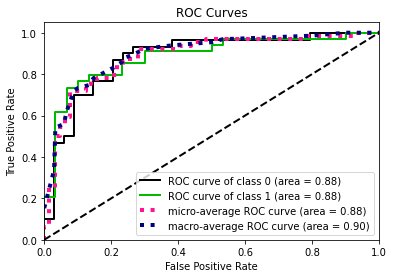

In [20]:
skplt.metrics.plot_roc(lab, out.detach().numpy())
plt.show()

In [21]:
model

GCN(
  (conv1): GCNConv(20, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)

In [22]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [23]:
train_graph_embeddings = []
for data in train_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

    model.conv3.register_forward_hook(get_activation('conv3'))
    output = model(data.x, data.edge_index, data.batch)
    conv3_feats = activation['conv3']

    for i in torch.unique(data.batch):
        node_indexes = (data.batch == i).nonzero().ravel()

        original_enc = data.x[node_indexes]


        desc = ''.join(list(enc.inverse_transform(original_enc).ravel()))

        d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':lab[i].tolist(), 'pred_val':out[i], 'conv3_feats':conv3_feats[node_indexes]}
        train_graph_embeddings.append(d)
len(train_graph_embeddings)    

576

In [24]:
test_graph_embeddings = []
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    lab = data.y

    model.conv3.register_forward_hook(get_activation('conv3'))
    output = model(data.x, data.edge_index, data.batch)
    conv3_feats = activation['conv3']

    for i in torch.unique(data.batch):
        node_indexes = (data.batch == i).nonzero().ravel()

        original_enc = data.x[node_indexes]


        desc = ''.join(list(enc.inverse_transform(original_enc).ravel()))

        d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':lab[i].tolist(), 'pred_val':out[i], 'conv3_feats':conv3_feats[node_indexes]}
        test_graph_embeddings.append(d)
len(test_graph_embeddings)    

64

In [25]:
all_graph_embeddings = test_graph_embeddings + train_graph_embeddings

## Graph level embedding

### All embeddings

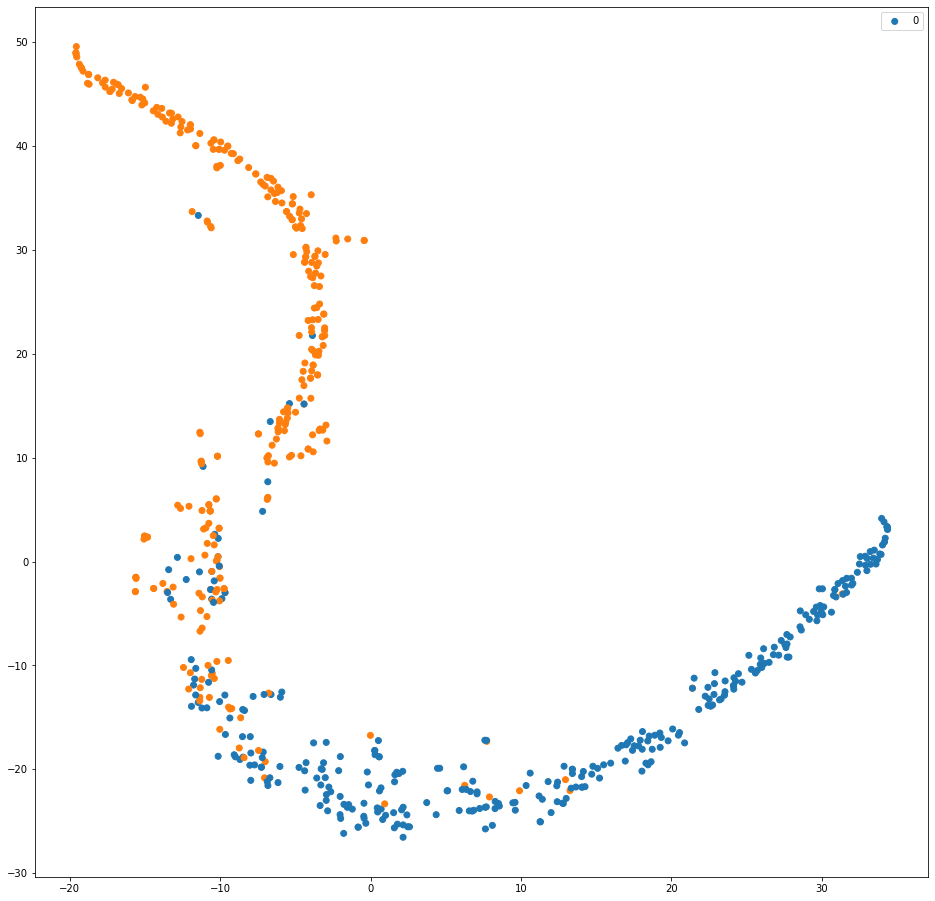

In [26]:
descs = []
conv_feats = np.zeros((len(all_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats[i] = all_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(all_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])
tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
plt.show()
#for i, l in enumerate(descs):
#    plt.annotate(l, (pca_embd[i, 0], pca_embd[i, 1]))

### Train

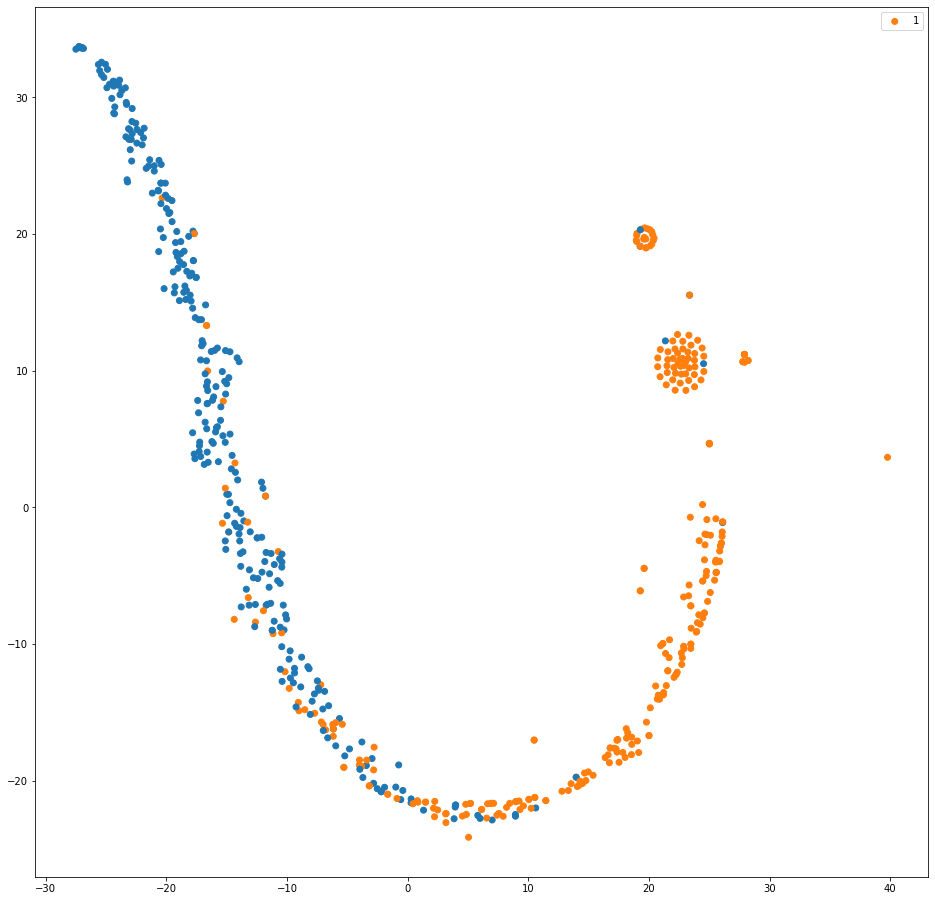

In [68]:
descs = []
conv_feats = np.zeros((len(train_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(train_graph_embeddings)):
    descs.append(train_graph_embeddings[i]['desc'])
    conv_feats[i] = train_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(train_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])

tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.legend(labels)
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
plt.show()
#for i, l in enumerate(descs):
#    plt.annotate(l, (pca_embd[i, 0], pca_embd[i, 1]))

#### Test

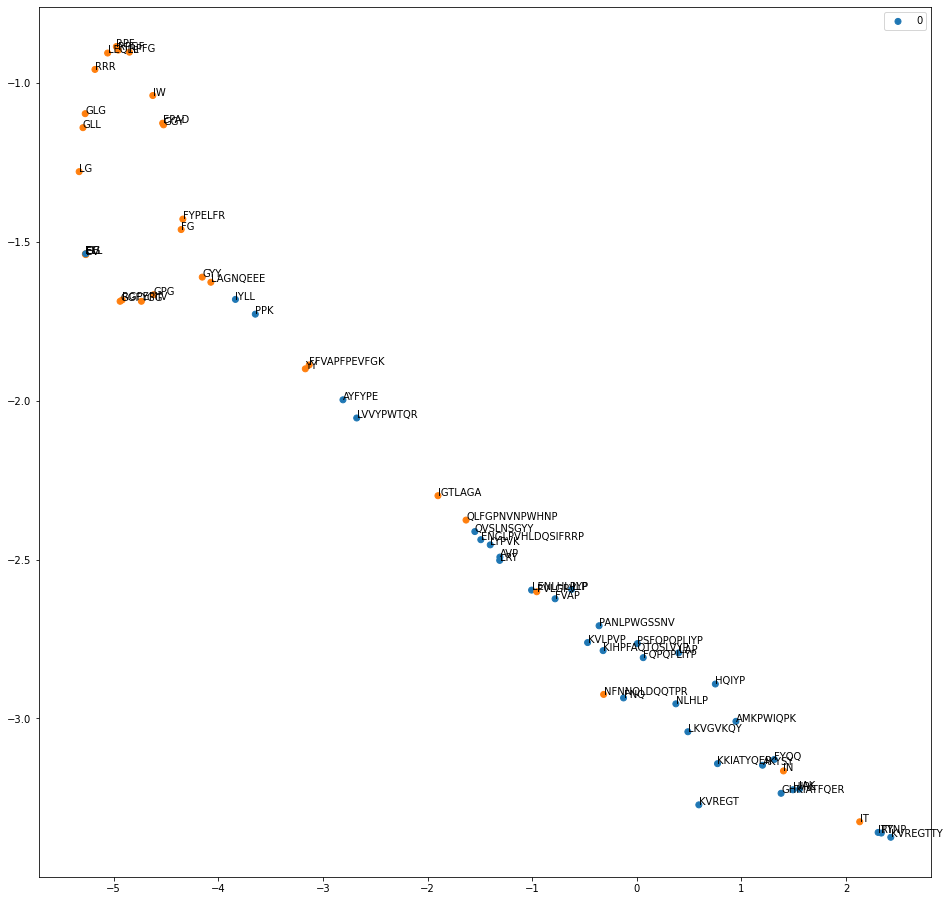

In [69]:
descs = []
conv_feats = np.zeros((len(test_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(test_graph_embeddings)):
    descs.append(test_graph_embeddings[i]['desc'])
    conv_feats[i] = test_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(test_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])

tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.legend(labels)
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
for i, l in enumerate(descs):
    plt.annotate(l, (tsne_embd[i, 0], tsne_embd[i, 1]))
plt.show()

## Node level embeddings: All Data 

In [70]:
descs = []
conv_feats = []
labels = []
pred_vals = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats.append(all_graph_embeddings[i]['conv3_feats'].mean(axis = 1).detach().tolist())
    labels.append(all_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])


In [92]:
pos_samples = []
neg_samples = []
for i in range(len(conv_feats)):
    if labels[i] == 1:
        pos_samples.append(np.mean(conv_feats[i]))
    else:
        neg_samples.append(np.mean(conv_feats[i]))

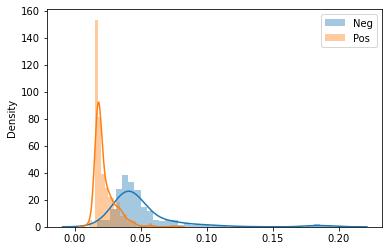

In [95]:
sns.distplot(neg_samples, label='Neg')
sns.distplot(pos_samples, label='Pos')
plt.legend()
plt.show()

del pos_samples, neg_samples

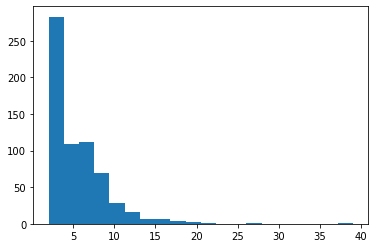

In [96]:
plt.hist([len(i) for i in descs], bins = 20)
plt.show()

In [97]:
pos_descs = {}
neg_descs = {}
for i in range(len(labels)):
    k = descs[i]
    v = conv_feats[i]
    if labels[i] == 1:
        for _, d in enumerate(k):
            if d in pos_descs.keys():
                pos_descs[d].append(v[_])
            else:
                pos_descs[d] = [v[_]]
    else:
        for _, d in enumerate(k):
            if d in neg_descs.keys():
                neg_descs[d].append(v[_])
            else:
                neg_descs[d] = [v[_]]

In [98]:
desc_keys = sorted(list(set(list(pos_descs.keys()) + list(neg_descs.keys()))))

In [99]:
pos_desc_avg = []
neg_desc_avg = []
desc_avg = []
pos_desc_count = np.arange(len(desc_keys))
neg_desc_count = np.arange(len(desc_keys))
for i, k in enumerate(desc_keys):
    if k in pos_descs.keys():
        pos_desc_avg.append(np.mean(pos_descs[k]))
        pos_desc_count[i] = pos_desc_count[i] + len(pos_descs[k])
    else:
        pos_desc_avg.append(0)

    if k in neg_descs.keys():
        neg_desc_avg.append(np.mean(neg_descs[k]))
        neg_desc_count[i] = neg_desc_count[i] + len(neg_descs[k])
    else:
        neg_desc_avg.append(0)

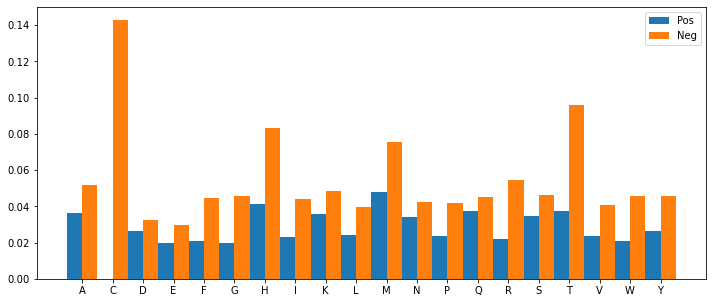

In [100]:
plt.figure(figsize=(12,5))
plt.bar(x=np.arange(20)-0.25, height = pos_desc_avg, width=-.5)
#plt.title('Bitter Descriptor Activations')
plt.bar(x=np.arange(20)+0.25, height = neg_desc_avg, width=-.5)
plt.xticks(np.arange(20), desc_keys)
plt.legend(['Pos', 'Neg'])
plt.show()

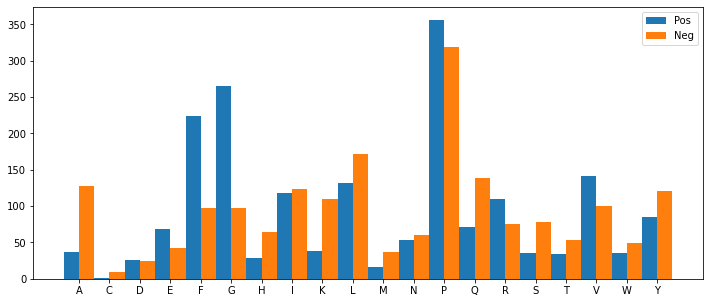

In [101]:
plt.figure(figsize=(12,5))
plt.bar(x=np.arange(20)-0.25, height = pos_desc_count, width=-.5)
#plt.title('Bitter Descriptor Activations')
plt.bar(x=np.arange(20)+0.25, height = neg_desc_count, width=-.5)
plt.xticks(np.arange(20), desc_keys)
plt.legend(['Pos', 'Neg'])
plt.show()

Seq: IP, Label: 1, Cls prob: [-0.19349455833435059, 0.4148099422454834]


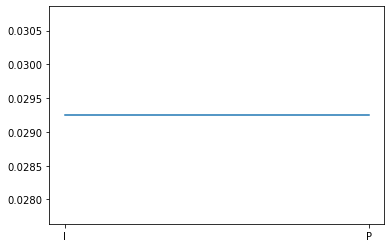

Seq: PKAIP, Label: 0, Cls prob: [0.6109800338745117, -0.5173584818840027]


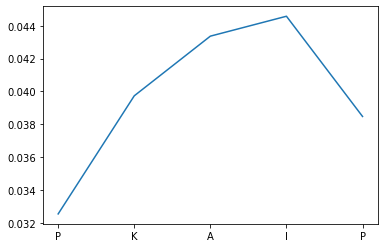

Seq: GYALPHA, Label: 0, Cls prob: [2.001887559890747, -2.1125833988189697]


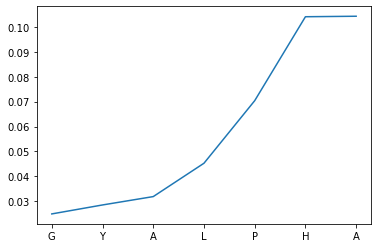

Seq: NALEPDHRVE, Label: 1, Cls prob: [0.06584063917398453, 0.17381155490875244]


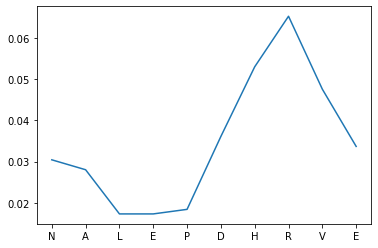

Seq: PK, Label: 1, Cls prob: [-0.6537138819694519, 0.994493305683136]


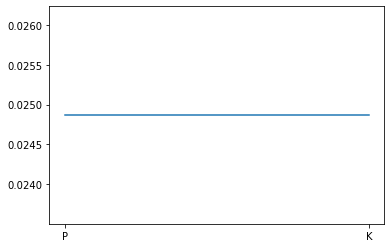

Seq: PVPQP, Label: 0, Cls prob: [0.41988155245780945, -0.28635990619659424]


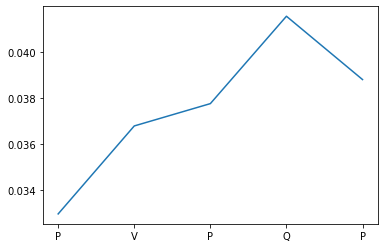

Seq: AP, Label: 0, Cls prob: [1.5243151187896729, -1.650958776473999]


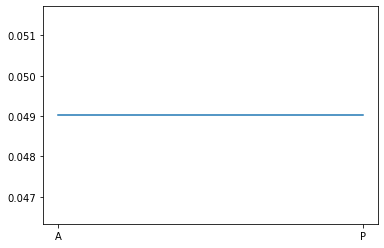

Seq: PSFQPQPLIYP, Label: 0, Cls prob: [0.7868470549583435, -0.7336022257804871]


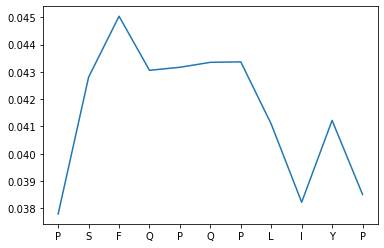

Seq: RR, Label: 1, Cls prob: [-1.216606855392456, 1.664347529411316]


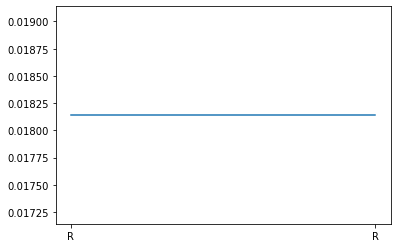

Seq: AVVRP, Label: 0, Cls prob: [0.03491666167974472, 0.1665681153535843]


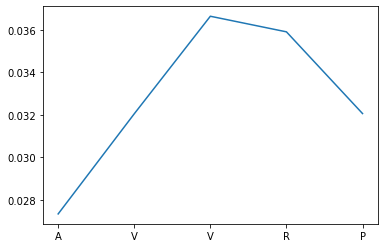

Seq: HIR, Label: 0, Cls prob: [4.704594612121582, -5.1895856857299805]


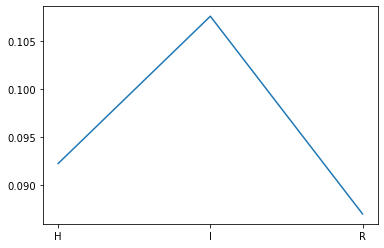

Seq: KIHPFAQTQSLVYP, Label: 0, Cls prob: [0.654390275478363, -0.53339684009552]


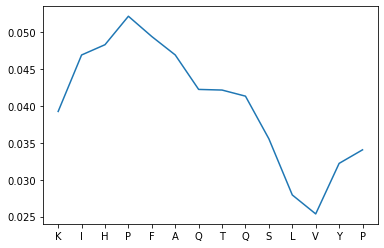

Seq: LAHKAL, Label: 0, Cls prob: [0.9367294311523438, -0.8841424584388733]


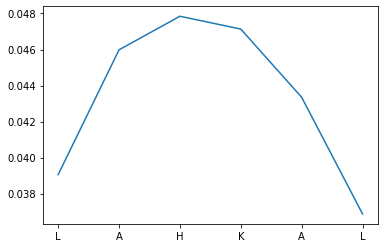

Seq: LSP, Label: 0, Cls prob: [0.45703989267349243, -0.35663872957229614]


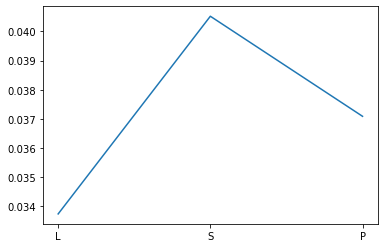

Seq: RGPEPIIV, Label: 1, Cls prob: [-1.1171791553497314, 1.525596022605896]


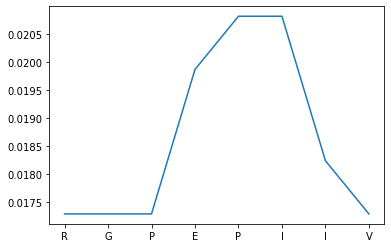

Seq: PNSHP, Label: 0, Cls prob: [1.1444144248962402, -1.0997743606567383]


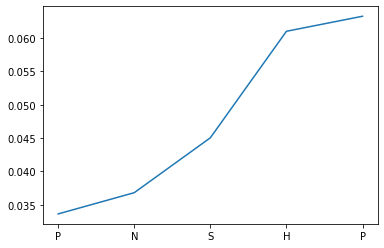

Seq: LAYFYP, Label: 0, Cls prob: [-0.13325493037700653, 0.34674760699272156]


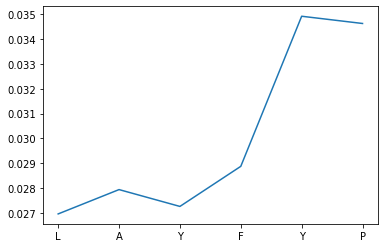

Seq: GV, Label: 1, Cls prob: [-0.47406190633773804, 0.7636643052101135]


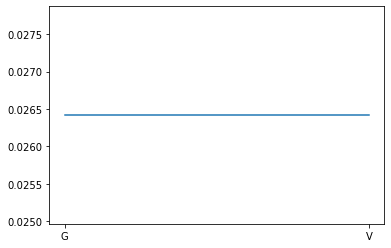

Seq: RGPPGFG, Label: 1, Cls prob: [-1.1807365417480469, 1.6054952144622803]


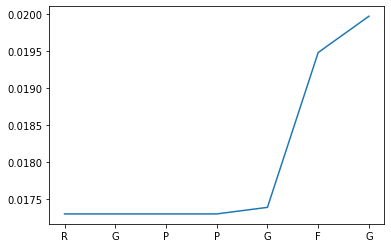

Seq: PKAIP, Label: 0, Cls prob: [0.6109800338745117, -0.5173584818840027]


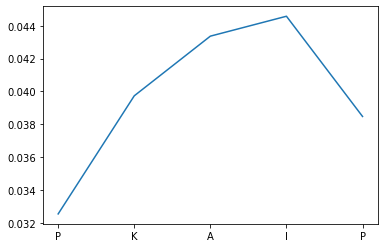

In [102]:
#i = np.random.randint(640)
#print(i)
for i in np.random.choice(640, 20):
    print(f'Seq: {descs[i]}, Label: {labels[i]}, Cls prob: {pred_vals[i].tolist()}')
    #print(f'Activation: {conv_feats[i]}')
    #plt.bar(x=np.arange(len(descs[i])), height = conv_feats[i], width=-.5)
    plt.plot(conv_feats[i])
    plt.xticks(np.arange(len(descs[i])), [c for c in descs[i]])
    plt.show()

Seq: KIHPFAQTQSLVYP, Label: 0, Cls prob: [0.654390275478363, -0.53339684009552]


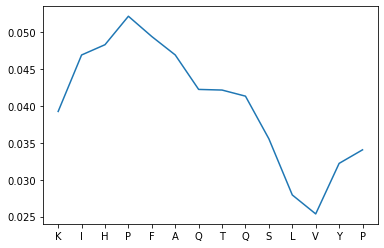

Seq: KIYPSFQPQPLIYP, Label: 0, Cls prob: [0.7675110101699829, -0.7110775709152222]


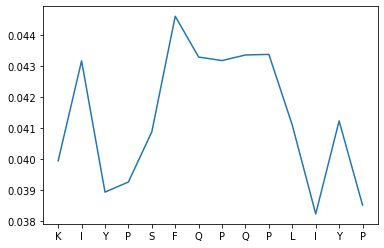

Seq: RGPPFIVRGPPFIV, Label: 1, Cls prob: [-0.9529335498809814, 1.336784839630127]


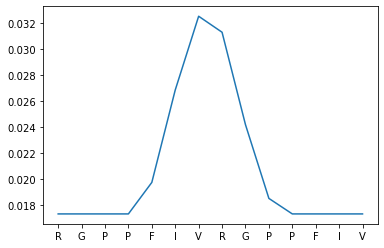

Seq: KVHSSIQSQPQAFT, Label: 0, Cls prob: [2.315647602081299, -2.4282822608947754]


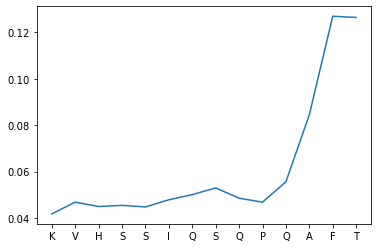

Seq: QPVLGPVRGPFPIIV, Label: 1, Cls prob: [-0.4230180084705353, 0.7116228342056274]


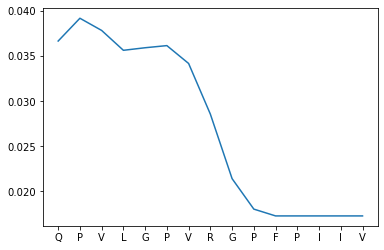

Seq: YQQPVLGPVRGPFPI, Label: 1, Cls prob: [0.11709712445735931, 0.07957270741462708]


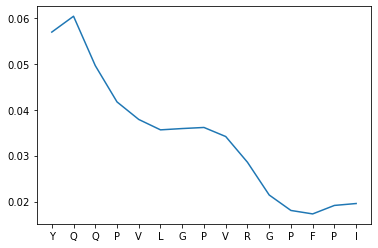

Seq: ENGLPVHLDQSIFRR, Label: 0, Cls prob: [0.17944975197315216, 0.031680792570114136]


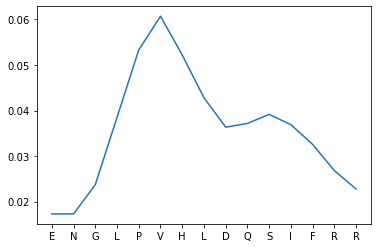

Seq: YQEPVLGPVRGPFPI, Label: 1, Cls prob: [-0.4122791886329651, 0.7029381990432739]


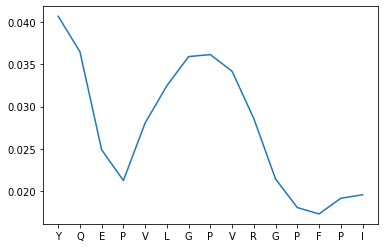

Seq: DKIYPSFQPQPLIYP, Label: 0, Cls prob: [0.7307285070419312, -0.665654718875885]


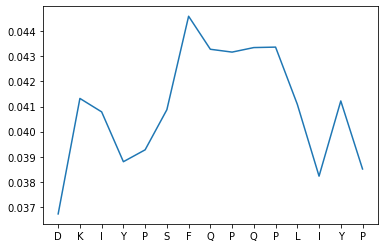

Seq: YQQPVLGPVRGPFPII, Label: 1, Cls prob: [0.05587176978588104, 0.15080809593200684]


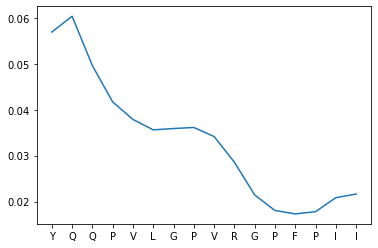

Seq: ENGLPVHLDQSIFRRP, Label: 0, Cls prob: [0.12172798067331314, 0.09372031688690186]


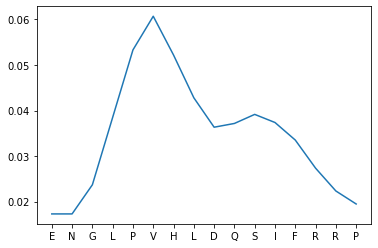

Seq: YQQPVLGPVRGPFPIIV, Label: 1, Cls prob: [-0.06261657923460007, 0.291187047958374]


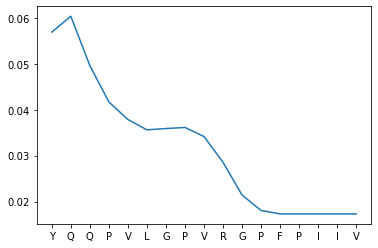

Seq: APKHKEMPFPKYPVEPF, Label: 1, Cls prob: [0.03565211966633797, 0.1848951131105423]


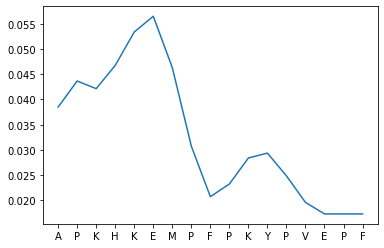

Seq: YQEPVLGPVRGPFPIIV, Label: 1, Cls prob: [-0.5297133922576904, 0.8412154316902161]


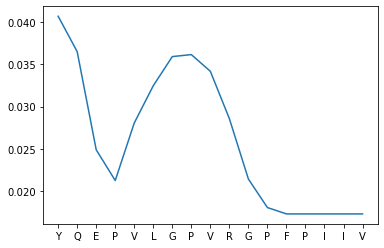

Seq: MAPKHKEMPFPKYPVEPF, Label: 1, Cls prob: [0.4073489308357239, -0.26182812452316284]


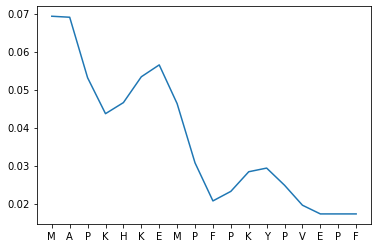

Seq: LVYPFPGPIPNSLPQNIPP, Label: 0, Cls prob: [-0.19836574792861938, 0.4432078003883362]


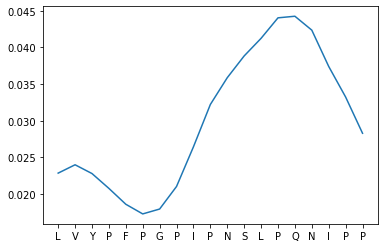

Seq: QDKIHPFAQTQSLVYPFPGP, Label: 1, Cls prob: [0.14755362272262573, 0.06073661893606186]


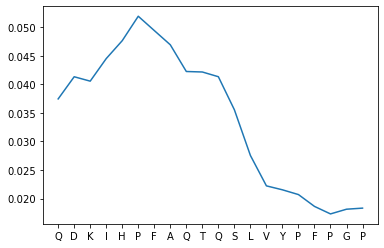

Seq: QNDKIHPFAQTQSLVYPFGPIP, Label: 1, Cls prob: [0.22243306040763855, -0.027727201581001282]


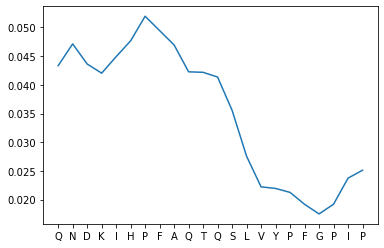

Seq: AQTQSLVYPFPGPIPNSLPQNIPPLTQ, Label: 1, Cls prob: [0.07950015366077423, 0.13241159915924072]


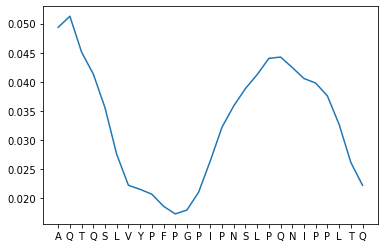

Seq: QNDKIHPFAQTQSLVYPFGPIPNSLPQNIPPLTQTPVVV, Label: 1, Cls prob: [0.39204463362693787, -0.22210772335529327]


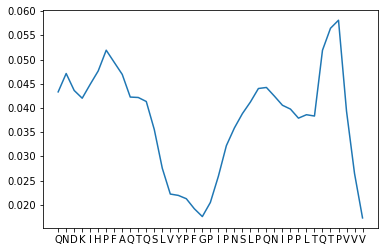

In [103]:
#i = np.random.randint(640)
#print(i)
for i in np.argsort([len(i) for i in descs])[-20:]:
    print(f'Seq: {descs[i]}, Label: {labels[i]}, Cls prob: {pred_vals[i].tolist()}')
    #print(f'Activation: {conv_feats[i]}')
    #plt.bar(x=np.arange(len(descs[i])), height = conv_feats[i], width=-.5)
    plt.plot(conv_feats[i])
    plt.xticks(np.arange(len(descs[i])), [c for c in descs[i]])
    plt.show()